In [46]:
import numpy as np
import gsw
import sys
import xarray as xray
import os
from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
basedir = '/data/scratch/takaya/POP_data/3D_data/'

In [85]:
fname = os.path.join(basedir, 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-0081.Jan.timeavg.nc')
ex = xray.open_dataset(fname, decode_times=False)

maskU = ex.KMU > 1
maskT = ex.KMT > 1
latT = ex.TLAT.where(maskT)
lonT = ex.TLONG.where(maskT)
latU = ex.ULAT.where(maskU)
lonU = ex.ULONG.where(maskU)

zMid = 1e-2 * ex.TEMP.z_t
zBot = 1e-2 * ex.z_w_bot
Po = 1e4 * gsw.p_from_z(-zMid.values[0, np.newaxis, np.newaxis], 
                     latT.values)   # 'z' has to be negative for the pressure function!!!

In [89]:
dz = np.diff(zMid)

In [88]:
print latT.values[:, 200], latU.values[:, 200]
print lonT.values[200], lonU.values[200]

[ nan  nan  nan ...,  nan  nan  nan] [ nan  nan  nan ...,  nan  nan  nan]
[ 250.05  250.15  250.25 ...,  249.75  249.85  249.95] [-109.9 -109.8 -109.7 ..., -110.2 -110.1 -110. ]


# Month matrix

In [51]:
winter_months = np.array(['Jan', 'Feb', 'Mar'])
summer_months = np.array(['Jul', 'Aug', 'Sep'])

In [52]:
npz = np.load(os.path.join(basedir, '../../OCCA/OCCA_global_monthly.npz'))
print npz.files
Ug_ref = npz['ugeo_at_Tpoints']
Vg_ref = npz['vgeo_at_Tpoints']

['vgeo_at_Tpoints', 'z_N2', 'latV', 'lonT', 'latT', 'absolute_salinity', 'z_center', 'beta', 'u_at_Tpoints', 'conservative_temperature', 'f0', 'ugeo_at_Tpoints', 'N2', 'z_top', 'lonU', 'v_at_Tpoints', 'potential_density']


# Solve geostrophic balance over the entire depth ($u_g, v_g$)

From geostrophic balance, we have

$$ \boldsymbol{u} = \frac{1}{f \rho_{ref}} \hat{\boldsymbol{z}} \times \nabla P \\ = \frac{g}{f \rho_{ref}}  \big{[} \langle \rho \rangle \ \hat{\boldsymbol{z}} \times \nabla \eta + (\eta - z) \ \hat{\boldsymbol{z}} \times \nabla \langle \rho \rangle \big{]} $$

Hence,

$$ u = \frac{g}{f \rho_{ref}} \big{[} \langle \rho \rangle \bigg( -\frac{\partial \eta}{\partial y} \bigg) + (\eta - z) \bigg( -\frac{\partial \langle \rho \rangle}{\partial y} \bigg) \big] $$

$$ v = \frac{g}{f \rho_{ref}} \big{[} \langle \rho \rangle \bigg( \frac{\partial \eta}{\partial x} \bigg) + (\eta - z) \bigg( \frac{\partial \langle \rho \rangle}{\partial x} \bigg) \big] $$

where $\langle \rho \rangle = \frac{1}{\eta + |z|} \int^{\eta}_z \rho \ dz$ is the mean density in the water column of depth $\eta - z$ .

## winter is coming...

In [15]:
t = 0
for mon in winter_months:
    
    fname = os.path.join(basedir, 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-0081.%3s.timeavg.nc' % mon)
    data = xray.open_dataset(fname, decode_times=False)
    print os.path.exists(fname), fname
    
#     salt = fname.SALT[0]
    maskU = data.KMU > 1
    maskT = data.KMT > 1
    theta = data.TEMP[0].where(maskT)
    salt = data.SALT[0].where(maskT)
    eta = 1e-2 * data.SSH[0].where(maskT)
    
    if mon == 'Jan':
        latT = data.TLAT.where(maskT)
        lonT = data.TLONG.where(maskT)
        zMid = 1e-2 * data.TEMP.z_t
        zBot = 1e-2 * data.z_w_bot
        zTop = 1e-2 * data.z_w_top
        dxU = 1e-2 * data.DXU.where(maskT)
        dyU = 1e-2 * data.DYU.where(maskT)
        f = gsw.earth.f(latT)
        Nz, Ny, Nx = theta.shape
        t_mat = np.empty((3, Nz, Ny, Nx))
        s_mat = np.empty((3, Nz, Ny, Nx))
        eta_mat = np.empty((3, Ny, Nx))
    
    t_mat[t] = theta.values
    s_mat[t] = salt.values
    eta_mat[t] = eta.values
    
    t += 1
    
save_name = os.path.join('POP_Parameters_winter')
print save_name
np.savez(save_name,
        lat=latT, lon=lonT, dx=dxU, dy=dyU,
        eta=np.nanmean(eta_mat, axis=0),
        coriolis=f, 
        z=zMid, zBot=zBot, zTop=zTop,
        salt=np.nanmean(s_mat, axis=0), theta=np.nanmean(t_mat, axis=0)
        )

True /data/scratch/takaya/POP_data/3D_data/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-0081.Jan.timeavg.nc
True /data/scratch/takaya/POP_data/3D_data/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-0081.Feb.timeavg.nc
True /data/scratch/takaya/POP_data/3D_data/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-0081.Mar.timeavg.nc
POP_Parameters_winter


In [53]:
npzfile = np.load(os.path.join(basedir, '../POP_Parameters_winter.npz'))
print npzfile.files
theta_win = npzfile['theta']
salt_win = npzfile['salt']
eta_win = npzfile['eta']

z = npzfile['z']
lat = npzfile['lat']
lon = npzfile['lon']
f = npzfile['coriolis']
zBot = npzfile['zBot']
dx = npzfile['dx']
dy = npzfile['dy']

['zTop', 'lon', 'coriolis', 'zBot', 'eta', 'dx', 'dy', 'lat', 'theta', 'z', 'salt']


In [20]:
print z

[  5.00000000e+00   1.50000000e+01   2.50000000e+01   3.50000000e+01
   4.50000000e+01   5.50000000e+01   6.50000000e+01   7.50000000e+01
   8.50000000e+01   9.50000000e+01   1.05000000e+02   1.15000000e+02
   1.25000000e+02   1.35000000e+02   1.45000000e+02   1.55000000e+02
   1.65098389e+02   1.75479034e+02   1.86291260e+02   1.97660263e+02
   2.09711380e+02   2.22578278e+02   2.36408829e+02   2.51370148e+02
   2.67654205e+02   2.85483643e+02   3.05119202e+02   3.26867981e+02
   3.51093475e+02   3.78227600e+02   4.08784637e+02   4.43377686e+02
   4.82736694e+02   5.27727966e+02   5.79372864e+02   6.38862610e+02
   7.07563293e+02   7.87002502e+02   8.78825195e+02   9.84705811e+02
   1.10620422e+03   1.24456689e+03   1.40049719e+03   1.57394641e+03
   1.76400330e+03   1.96894421e+03   2.18645654e+03   2.41397144e+03
   2.64900122e+03   2.88938452e+03   3.13340454e+03   3.37979346e+03
   3.62767017e+03   3.87645190e+03   4.12576807e+03   4.37539258e+03
   4.62519043e+03   4.87508350e+03

In [34]:
p_win = gsw.p_from_z(eta_win - z[:, np.newaxis, np.newaxis], 
                     lat[np.newaxis])
absS_win = gsw.SA_from_SP(salt_win, 
                      p_win, lon[np.newaxis], lat[np.newaxis])
consT_win = gsw.CT_from_pt(absS_win, theta_win)

In [35]:
np.savez('POP_ThermalVariables_winter',
        pressure=p_win, absS=absS_win, consT=consT_win)

In [56]:
TVnpz = np.load(os.path.join(basedir, '../POP_ThermalVariables_winter.npz'))
print TVnpz.files
p_win = TVnpz['pressure']
absS_win = TVnpz['absS']
consT_win = TVnpz['consT']

['pressure', 'consT', 'absS']


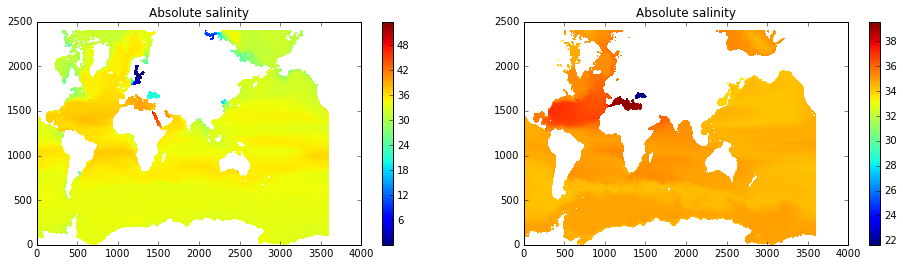

In [25]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh( np.ma.masked_invalid(
        absS_win[0]), cmap='jet')
ax1.set_title(r'Absolute salinity')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh( np.ma.masked_invalid(
        absS_win[30]), cmap='jet')
ax2.set_title(r'Absolute salinity')
fig.colorbar(cax2)

In [57]:
Ny, Nx = eta_win.shape
Nz = len(z)+1
z_surfBot = np.zeros((Nz, Ny, Nx))

for j in range(Ny):
    for i in range(Nx):
        z_surfBot[:, j, i] = np.append(-eta_win[j, i], zBot)
dz_win = np.diff(z_surfBot, axis=0)

print z, dz_win.shape

[  5.00000000e+00   1.50000000e+01   2.50000000e+01   3.50000000e+01
   4.50000000e+01   5.50000000e+01   6.50000000e+01   7.50000000e+01
   8.50000000e+01   9.50000000e+01   1.05000000e+02   1.15000000e+02
   1.25000000e+02   1.35000000e+02   1.45000000e+02   1.55000000e+02
   1.65098389e+02   1.75479034e+02   1.86291260e+02   1.97660263e+02
   2.09711380e+02   2.22578278e+02   2.36408829e+02   2.51370148e+02
   2.67654205e+02   2.85483643e+02   3.05119202e+02   3.26867981e+02
   3.51093475e+02   3.78227600e+02   4.08784637e+02   4.43377686e+02
   4.82736694e+02   5.27727966e+02   5.79372864e+02   6.38862610e+02
   7.07563293e+02   7.87002502e+02   8.78825195e+02   9.84705811e+02
   1.10620422e+03   1.24456689e+03   1.40049719e+03   1.57394641e+03
   1.76400330e+03   1.96894421e+03   2.18645654e+03   2.41397144e+03
   2.64900122e+03   2.88938452e+03   3.13340454e+03   3.37979346e+03
   3.62767017e+03   3.87645190e+03   4.12576807e+03   4.37539258e+03
   4.62519043e+03   4.87508350e+03

In [58]:
rho_win = gsw.rho(absS_win, consT_win, 0.)

rho_brack_win = (eta_win[np.newaxis] 
                 + zBot[:, np.newaxis, np.newaxis])**-1 * np.cumsum(rho_win * dz_win, axis=0)

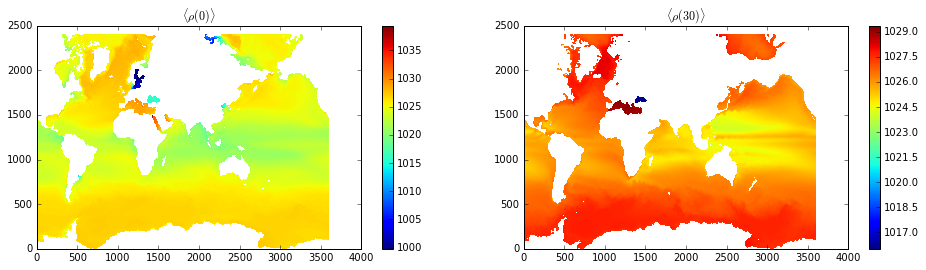

In [64]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh( np.ma.masked_invalid(
        rho_brack_win[0]), cmap='jet')
ax1.set_title(r'$\langle \rho(0) \rangle$')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh( np.ma.masked_invalid(
        rho_brack_win[30]), cmap='jet')
ax2.set_title(r'$\langle \rho(30) \rangle$')
fig.colorbar(cax2)

In [59]:
detadx_win = (np.roll(eta_win, -1, axis=1) - eta_win) / dx
detady_win = (np.roll(eta_win, -1, axis=0) - eta_win) / dy
drhodx_win = (np.roll(rho_brack_win, -1, axis=2) - rho_brack_win) / dx[np.newaxis]
drhody_win = (np.roll(rho_brack_win, -1, axis=1) - rho_brack_win)[:] / dy[np.newaxis]

In [60]:
def aggregate(data, factor=2, mean=True):
    ndim = data.ndim
    shape = data.shape
    # promote single value to list
    if isinstance(factor, int):
        factors = ndim * [factor,]
#         print 'ndim: ', ndim, ' factors: ', factors
    # check we have the right number of dimensions
    assert len(factors) == ndim
    # make sure shapes are compatible
    for s, fac in zip(shape, factors):
#         print 's: ', s, ' fac: ', fac
        assert s % factor == 0
    out = 0
    # it is lazy to use a set...don't have to figure out the necessary logic
    slices = []
    for start_indices in product(*[range(f) for f in factors]):
        slices.append(
            [slice(sidx, s, factor) for sidx, s in zip(start_indices, shape)]
        )
    
    # how would we generalize to other reduce functions?
    result = reduce(np.add, [data[sl] for sl in slices])
    if mean:
        result /= len(slices)
    return result

## $\boldsymbol{u}_g$

In [61]:
latUg = .5 * (np.roll(lat, -1, axis=0) + lat)
rho_winUg0 = .5 * (np.roll(rho_win[0], -1, axis=0) + rho_win[0])
rho_brack_winUg = .5 * (np.roll(rho_brack_win, -1, axis=1) + rho_brack_win)
etaUg_win = .5 * (np.roll(eta_win, -1, axis=0) + eta_win)

In [66]:
Ug_win = -9.8 * (gsw.earth.f(latUg)[np.newaxis] 
                               * rho_winUg0[np.newaxis])**-1 * (rho_brack_winUg * detady_win[np.newaxis] 
                               + (-etaUg_win[np.newaxis] + zBot[:, np.newaxis, np.newaxis]) * drhody_win)

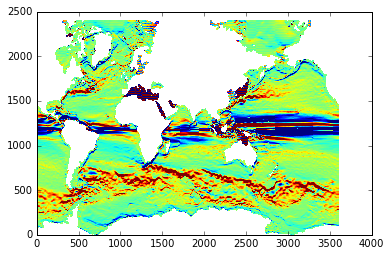

In [68]:
plt.pcolormesh(np.ma.masked_invalid(Ug_win[0]), vmin=-.2, vmax=.2)

In [69]:
print Ug_win.shape

(62, 2400, 3600)


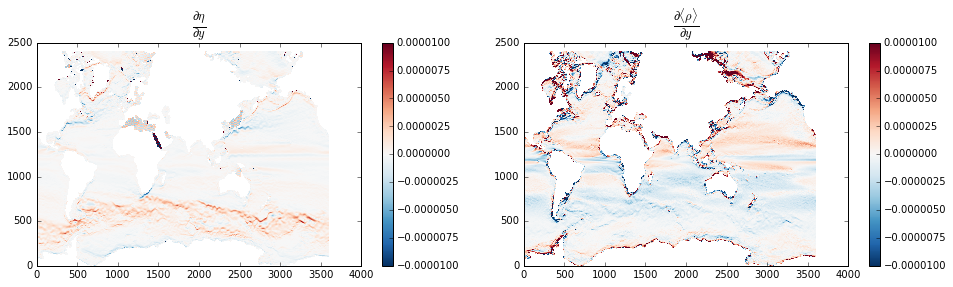

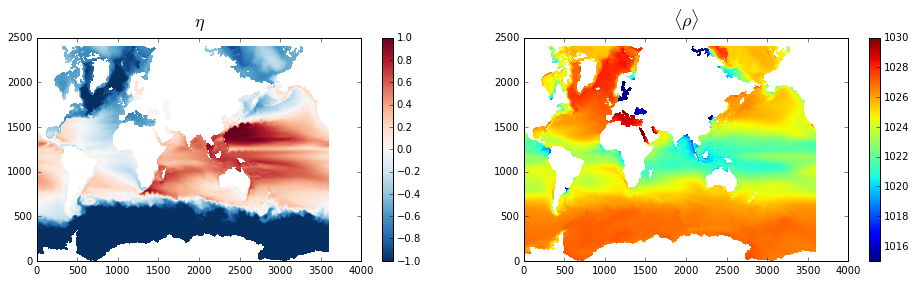

In [62]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(detady_win), 
                       cmap='RdBu_r', vmin=-1e-5, vmax=1e-5)
ax1.set_title(r'$\frac{\partial \eta}{\partial y}$', fontsize=18, y=1.03)
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(drhody_win[0]), 
                       cmap='RdBu_r', vmin=-1e-5, vmax=1e-5)
ax2.set_title(r'$\frac{\partial \langle \rho \rangle}{\partial y}$', fontsize=18, y=1.03)
fig.colorbar(cax2)

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(etaUg_win), 
                       cmap='RdBu_r', vmin=-1e0, vmax=1e0)
ax1.set_title(r'$\eta$', fontsize=18, y=1.03)
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(rho_brack_winUg[0]), 
                       cmap='jet', vmin=1015, vmax=1030)
ax2.set_title(r'$\langle \rho \rangle$', fontsize=18, y=1.03)
fig.colorbar(cax2)

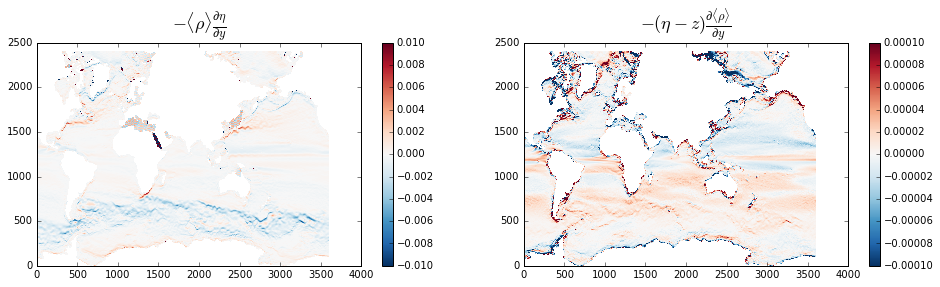

In [45]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(-rho_brack_winUg[0]* detady_win), 
                       cmap='RdBu_r', vmin=-1e-2, vmax=1e-2)
ax1.set_title(r'$-\langle \rho \rangle \frac{\partial \eta}{\partial y}$', fontsize=18, y=1.03)
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(-(-etaUg_win+zBot[0])*drhody_win[0]), 
                       cmap='RdBu_r', vmin=-1e-4, vmax=1e-4)
ax2.set_title(r'$-(\eta - z) \frac{\partial \langle \rho \rangle}{\partial y}$', fontsize=18, y=1.03)
fig.colorbar(cax2)

In [63]:
Nagg = 10

rho_brack_winUg_agg = np.empty((rho_brack_winUg.shape[0],
                  rho_brack_winUg.shape[1]/Nagg, rho_brack_winUg.shape[2]/Nagg))
rho_brack_winUg_agg[:] = np.nan
rho_winUg0_agg = np.empty((rho_winUg0.shape[0]/Nagg, rho_winUg0.shape[1]/Nagg))
rho_winUg0_agg[:] = np.nan
drhody_win_agg = np.empty((drhody_win.shape[0],
                  drhody_win.shape[1]/Nagg, drhody_win.shape[2]/Nagg))
drhody_win_agg[:] = np.nan


for k in range(Nz-1):

    if k == 0:
        latUg_agg = aggregate(latUg, factor=Nagg)
        lon_agg = aggregate(lon, factor=Nagg)
        etaUg_win_agg = aggregate(etaUg_win, factor=Nagg)
        detady_win_agg = aggregate(detady_win, factor=Nagg)
        rho_winUg0_agg = aggregate(rho_winUg0, factor=Nagg)

    rho_brack_winUg_agg[k] = aggregate(rho_brack_winUg[k], factor=Nagg)
    drhody_win_agg[k] = aggregate(drhody_win[k], factor=Nagg)

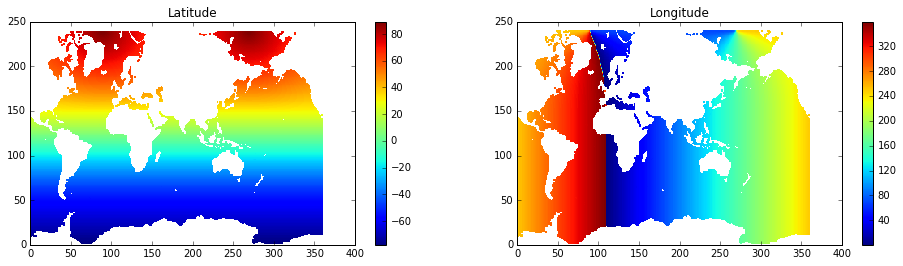

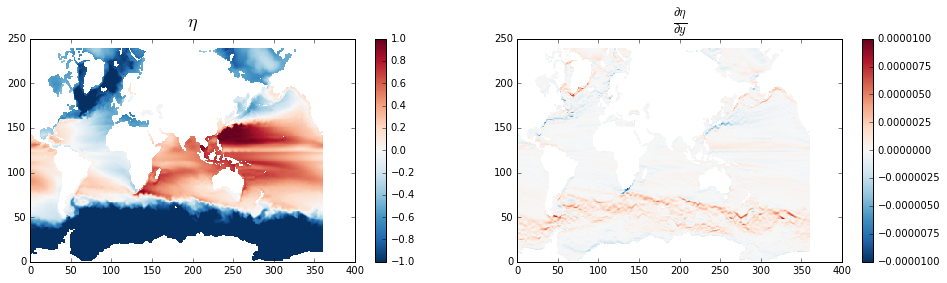

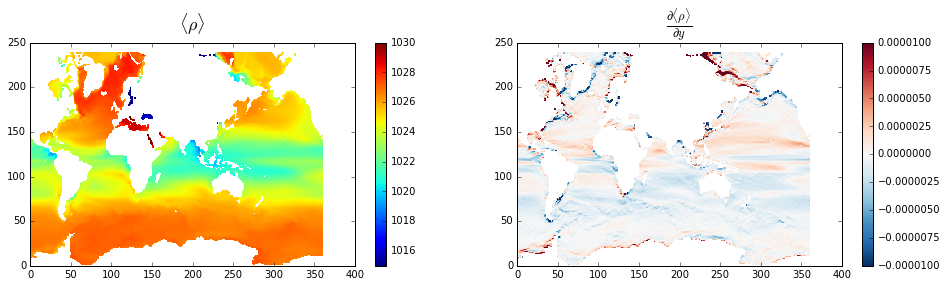

In [82]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(latUg_agg), 
                       cmap='jet')
ax1.set_title(r'Latitude')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(lon_agg), 
                       cmap='jet')
ax2.set_title(r'Longitude')
fig.colorbar(cax2)

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(etaUg_win_agg), 
                       cmap='RdBu_r', vmin=-1e0, vmax=1e0)
ax1.set_title(r'$\eta$', fontsize=18, y=1.03)
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(detady_win_agg), 
                       cmap='RdBu_r', vmin=-1e-5, vmax=1e-5)
ax2.set_title(r'$\frac{\partial \eta}{\partial y}$', fontsize=18, y=1.03)
fig.colorbar(cax2)

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(rho_brack_winUg_agg[0]), 
                       cmap='jet', vmin=1015, vmax=1030)
ax1.set_title(r'$\langle \rho \rangle$', fontsize=18, y=1.03)
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(drhody_win_agg[0]), 
                       cmap='RdBu_r', vmin=-1e-5, vmax=1e-5)
ax2.set_title(r'$\frac{\partial \langle \rho \rangle}{\partial y}$', fontsize=18, y=1.03)
fig.colorbar(cax2)

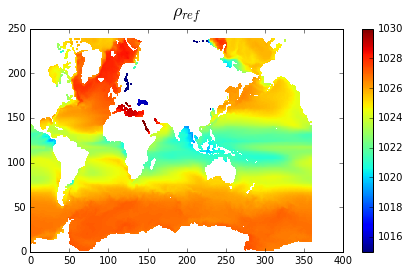

In [83]:
fig = plt.figure(figsize=(7,4))

ax = plt.gca()
cax = ax.pcolormesh(np.ma.masked_invalid(rho_winUg0_agg), 
                       cmap='jet', vmin=1015, vmax=1030)
ax.set_title(r'$\rho_{ref}$', fontsize=18, y=1.03)
fig.colorbar(cax)

In [64]:
Ug_win_agg = -9.8 * (gsw.earth.f(latUg_agg)[np.newaxis] 
                               * rho_winUg0_agg[np.newaxis])**-1 * (rho_brack_winUg_agg * detady_win_agg[np.newaxis] 
                               + (-etaUg_win_agg[np.newaxis] + zBot[:, np.newaxis, np.newaxis]) * drhody_win_agg)

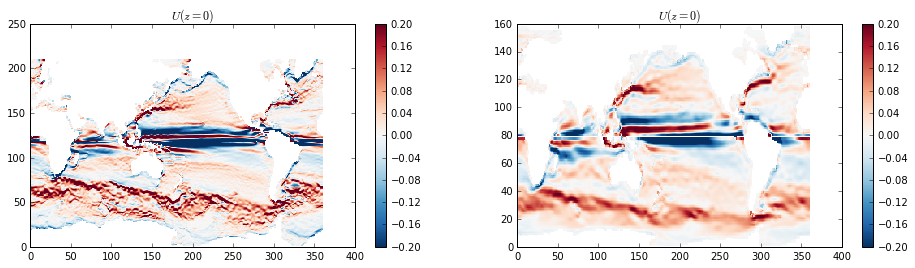

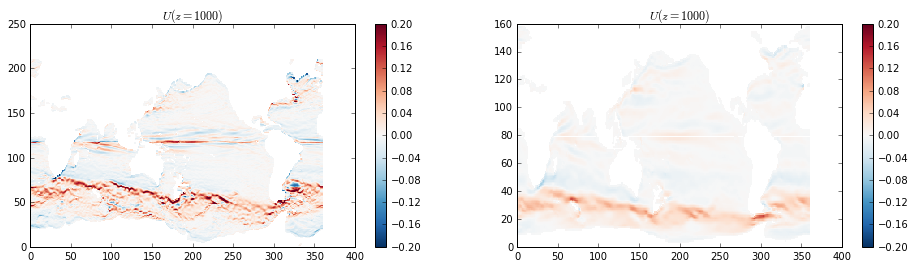

In [65]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(np.roll(Ug_win_agg[0, :210], -100, axis=1)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax1.set_title(r'$U (z=0)$')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(np.nanmean(Ug_ref[:3, 0], axis=0)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax2.set_title(r'$U (z=0)$')
fig.colorbar(cax2)

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(np.roll(Ug_win_agg[39, :210], -100, axis=1)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax1.set_title(r'$U (z=1000)$')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(np.nanmean(Ug_ref[:3, 29], axis=0)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax2.set_title(r'$U (z=1000)$')
fig.colorbar(cax2)

## $\boldsymbol{v}_g$

In [71]:
lonVg = .5 * (np.roll(lon, -1, axis=1) + lon)
rho_winVg0 = .5 * (np.roll(rho_win[0], -1, axis=1) + rho_win[0])
rho_brack_winVg = .5 * (np.roll(rho_brack_win, -1, axis=2) + rho_brack_win)
etaVg_win = .5 * (np.roll(eta_win, -1, axis=1) + eta_win)

In [72]:
Vg_win = 9.8 * (gsw.earth.f(lat)[np.newaxis] 
                               * rho_winVg0[np.newaxis])**-1 * (rho_brack_winVg * detadx_win[np.newaxis] 
                               + (-etaVg_win[np.newaxis] + zBot[:, np.newaxis, np.newaxis]) * drhodx_win)

In [73]:
np.savez('POP_geostrophicVel_winter_nonagg',
        lonU=lon, latU=latUg, lonV=lonVg, latV=lat,
        Ug=Ug_win, Vg=Vg_win)

In [88]:
Nagg = 10

rho_brack_winVg_agg = np.empty((rho_brack_winVg.shape[0],
                  rho_brack_winVg.shape[1]/Nagg, rho_brack_winVg.shape[2]/Nagg))
rho_brack_winVg_agg[:] = np.nan
rho_winVg0_agg = np.empty((rho_winVg0.shape[0]/Nagg, rho_winVg0.shape[1]/Nagg))
rho_winVg0_agg[:] = np.nan
drhodx_win_agg = np.empty((drhodx_win.shape[0],
                  drhodx_win.shape[1]/Nagg, drhodx_win.shape[2]/Nagg))
drhodx_win_agg[:] = np.nan


for k in range(Nz-1):

    if k == 0:
        lonVg_agg = aggregate(lonVg, factor=Nagg)
        lat_agg = aggregate(lat, factor=Nagg)
        etaVg_win_agg = aggregate(etaVg_win, factor=Nagg)
        detadx_win_agg = aggregate(detadx_win, factor=Nagg)
        rho_winVg0_agg = aggregate(rho_winVg0, factor=Nagg)

    rho_brack_winVg_agg[k] = aggregate(rho_brack_winVg[k], factor=Nagg)
    drhodx_win_agg[k] = aggregate(drhodx_win[k], factor=Nagg)

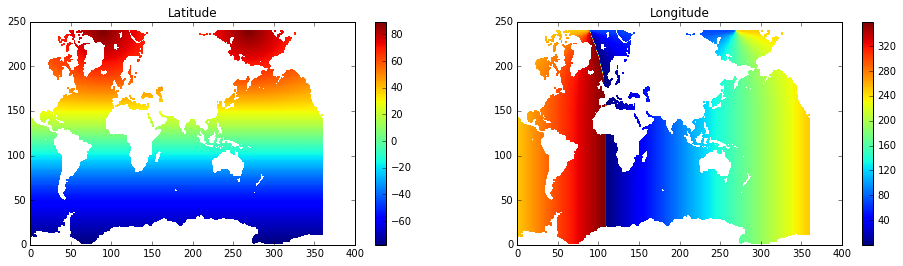

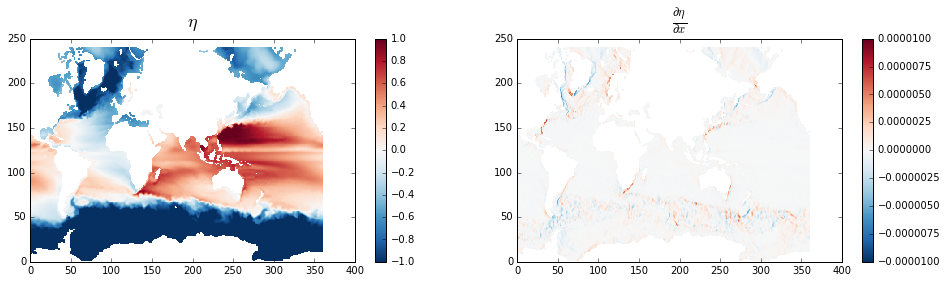

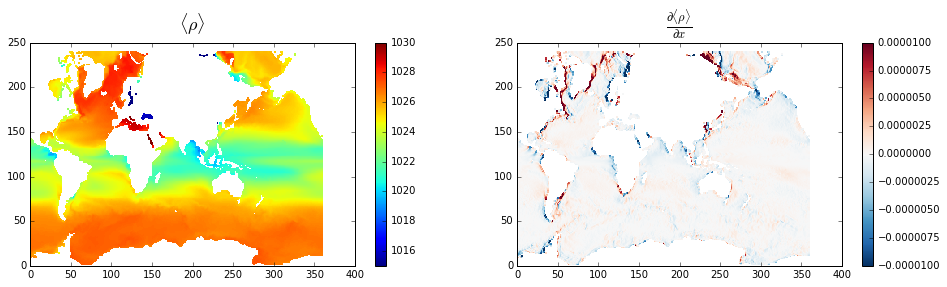

In [89]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(lat_agg), 
                       cmap='jet')
ax1.set_title(r'Latitude')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(lonVg_agg), 
                       cmap='jet')
ax2.set_title(r'Longitude')
fig.colorbar(cax2)

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(etaVg_win_agg), 
                       cmap='RdBu_r', vmin=-1e0, vmax=1e0)
ax1.set_title(r'$\eta$', fontsize=18, y=1.03)
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(detadx_win_agg), 
                       cmap='RdBu_r', vmin=-1e-5, vmax=1e-5)
ax2.set_title(r'$\frac{\partial \eta}{\partial x}$', fontsize=18, y=1.03)
fig.colorbar(cax2)

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(rho_brack_winVg_agg[0]), 
                       cmap='jet', vmin=1015, vmax=1030)
ax1.set_title(r'$\langle \rho \rangle$', fontsize=18, y=1.03)
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(drhodx_win_agg[0]), 
                       cmap='RdBu_r', vmin=-1e-5, vmax=1e-5)
ax2.set_title(r'$\frac{\partial \langle \rho \rangle}{\partial x}$', fontsize=18, y=1.03)
fig.colorbar(cax2)

In [92]:
Vg_win_agg = 9.8 * (gsw.earth.f(lat_agg)[np.newaxis] 
                               * rho_winVg0_agg[np.newaxis])**-1 * (rho_brack_winVg_agg * detadx_win_agg[np.newaxis] 
                               + (-etaVg_win_agg[np.newaxis] + zBot[:, np.newaxis, np.newaxis]) * drhodx_win_agg)

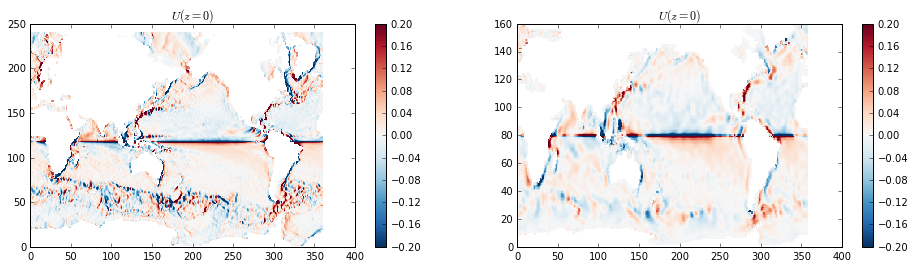

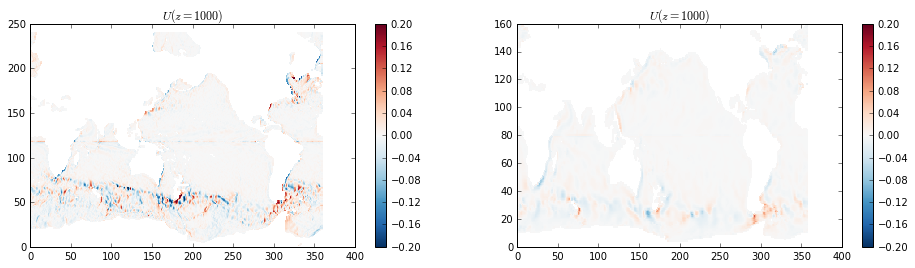

In [93]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(np.roll(Vg_win_agg[0], -100, axis=1)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax1.set_title(r'$U (z=0)$')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(np.nanmean(Vg_ref[:3, 0], axis=0)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax2.set_title(r'$U (z=0)$')
fig.colorbar(cax2)

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(np.roll(Vg_win_agg[39], -100, axis=1)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax1.set_title(r'$U (z=1000)$')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(np.nanmean(Vg_ref[:3, 29], axis=0)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax2.set_title(r'$U (z=1000)$')
fig.colorbar(cax2)

In [97]:
np.savez('POP_geostrophicVel_winter',
        Ug=Ug_win_agg, Vg=Vg_win_agg,
        latUg=latUg_agg, lon=lon_agg,
        lat=lat_agg, lonVg=lonVg_agg)

## summer

In [ ]:
t = 0
for mon in summer_months:
    
    fname = os.path.join(basedir, 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-0081.%3s.timeavg.nc' % mon)
    data = xray.open_dataset(fname, decode_times=False)
    print os.path.exists(fname), fname
    
#     salt = fname.SALT[0]
    maskU = data.KMU > 1
    maskT = data.KMT > 1
    theta = data.TEMP[0].where(maskT)
    salt = data.SALT[0].where(maskT)
    eta = 1e-2 * data.SSH[0].where(maskT)
    
    if mon == 'Jul':
        latT = data.TLAT.where(maskT)
        lonT = data.TLONG.where(maskT)
        zMid = 1e-2 * data.TEMP.z_t
        zBot = 1e-2 * data.z_w_bot
        zTop = 1e-2 * data.z_w_top
        dxU = 1e-2 * data.DXU.where(maskT)
        dyU = 1e-2 * data.DYU.where(maskT)
        f = gsw.earth.f(latT)
        Nz, Ny, Nx = theta.shape
        t_mat = np.empty((3, Nz, Ny, Nx))
        s_mat = np.empty((3, Nz, Ny, Nx))
        eta_mat = np.empty((3, Ny, Nx))
    
    t_mat[t] = theta.values
    s_mat[t] = salt.values
    eta_mat[t] = eta.values
    
    t += 1
    
save_name = os.path.join('POP_Parameters_summer')
print save_name
np.savez(save_name,
        lat=latT, lon=lonT, dx=dxU, dy=dyU,
        eta=np.nanmean(eta_mat, axis=0),
        coriolis=f, 
        z=zMid, zBot=zBot, zTop=zTop,
        salt=np.nanmean(s_mat, axis=0), theta=np.nanmean(t_mat, axis=0)
        )

True /data/scratch/takaya/POP_data/3D_data/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-0081.Jul.timeavg.nc


In [74]:
npzfile = np.load(os.path.join(basedir, '../POP_Parameters_summer.npz'))
print npzfile.files
theta_sum = npzfile['theta']
salt_sum = npzfile['salt']
eta_sum = npzfile['eta']

z = npzfile['z']
lat = npzfile['lat']
lon = npzfile['lon']
f = npzfile['coriolis']
zBot = npzfile['zBot']
dx = npzfile['dx']
dy = npzfile['dy']

['zTop', 'lon', 'coriolis', 'zBot', 'eta', 'dx', 'dy', 'lat', 'theta', 'z', 'salt']


In [37]:
p_sum = gsw.p_from_z(eta_sum - z[:, np.newaxis, np.newaxis], 
                     lat[np.newaxis])
absS_sum = gsw.SA_from_SP(salt_sum, 
                      p_sum, lon[np.newaxis], lat[np.newaxis])
consT_sum = gsw.CT_from_pt(absS_sum, theta_sum)

In [38]:
np.savez('POP_ThermalVariables_summer',
        pressure=p_sum, absS=absS_sum, consT=consT_sum)

In [76]:
TVnpz = np.load(os.path.join(basedir, '../POP_ThermalVariables_summer.npz'))
print TVnpz.files
p_sum = TVnpz['pressure']
absS_sum = TVnpz['absS']
consT_sum = TVnpz['consT']

['pressure', 'consT', 'absS']


In [77]:
Ny, Nx = eta_sum.shape
Nz = len(z)+1
z_surfBot = np.zeros((Nz, Ny, Nx))

for j in range(Ny):
    for i in range(Nx):
        z_surfBot[:, j, i] = np.append(-eta_sum[j, i], zBot)
dz_sum = np.diff(z_surfBot, axis=0)

print z, dz_sum.shape

[  5.00000000e+00   1.50000000e+01   2.50000000e+01   3.50000000e+01
   4.50000000e+01   5.50000000e+01   6.50000000e+01   7.50000000e+01
   8.50000000e+01   9.50000000e+01   1.05000000e+02   1.15000000e+02
   1.25000000e+02   1.35000000e+02   1.45000000e+02   1.55000000e+02
   1.65098389e+02   1.75479034e+02   1.86291260e+02   1.97660263e+02
   2.09711380e+02   2.22578278e+02   2.36408829e+02   2.51370148e+02
   2.67654205e+02   2.85483643e+02   3.05119202e+02   3.26867981e+02
   3.51093475e+02   3.78227600e+02   4.08784637e+02   4.43377686e+02
   4.82736694e+02   5.27727966e+02   5.79372864e+02   6.38862610e+02
   7.07563293e+02   7.87002502e+02   8.78825195e+02   9.84705811e+02
   1.10620422e+03   1.24456689e+03   1.40049719e+03   1.57394641e+03
   1.76400330e+03   1.96894421e+03   2.18645654e+03   2.41397144e+03
   2.64900122e+03   2.88938452e+03   3.13340454e+03   3.37979346e+03
   3.62767017e+03   3.87645190e+03   4.12576807e+03   4.37539258e+03
   4.62519043e+03   4.87508350e+03

In [78]:
rho_sum = gsw.rho(absS_sum, consT_sum, 0.)

rho_brack_sum = (eta_sum[np.newaxis] 
                 + zBot[:, np.newaxis, np.newaxis])**-1 * np.cumsum(rho_sum * dz_sum, axis=0)

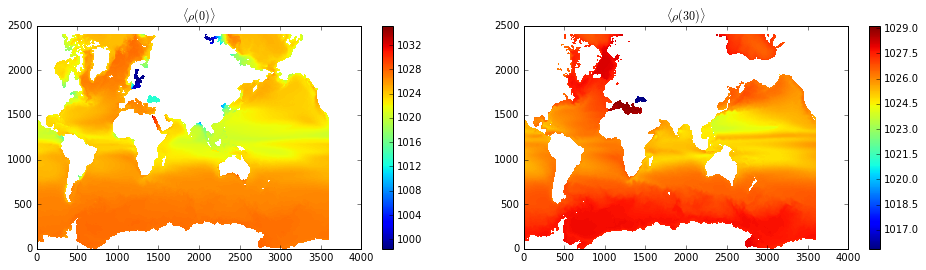

In [11]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh( np.ma.masked_invalid(
        rho_brack_sum[0]), cmap='jet')
ax1.set_title(r'$\langle \rho(0) \rangle$')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh( np.ma.masked_invalid(
        rho_brack_sum[30]), cmap='jet')
ax2.set_title(r'$\langle \rho(30) \rangle$')
fig.colorbar(cax2)

In [79]:
detadx_sum = (np.roll(eta_sum, -1, axis=1) - eta_sum) / dx
detady_sum = (np.roll(eta_sum, -1, axis=0) - eta_sum) / dy
drhodx_sum = (np.roll(rho_brack_sum, -1, axis=2) - rho_brack_sum) / dx[np.newaxis]
drhody_sum = (np.roll(rho_brack_sum, -1, axis=1) - rho_brack_sum) / dy[np.newaxis]

## $\boldsymbol{u}_g$

In [80]:
latUg = .5 * (np.roll(lat, -1, axis=0) + lat)
rho_sumUg0 = .5 * (np.roll(rho_sum[0], -1, axis=0) + rho_sum[0])
rho_brack_sumUg = .5 * (np.roll(rho_brack_sum, -1, axis=1) + rho_brack_sum)
etaUg_sum = .5 * (np.roll(eta_sum, -1, axis=0) + eta_sum)

In [81]:
Ug_sum = -9.8 * (gsw.earth.f(latUg)[np.newaxis] 
                               * rho_sumUg0[np.newaxis])**-1 * (rho_brack_sumUg * detady_sum[np.newaxis] 
                               + (-etaUg_sum[np.newaxis] + zBot[:, np.newaxis, np.newaxis]) * drhody_sum)

In [21]:
Nagg = 10

rho_brack_sumUg_agg = np.empty((rho_brack_sumUg.shape[0],
                  rho_brack_sumUg.shape[1]/Nagg, rho_brack_sumUg.shape[2]/Nagg))
rho_brack_sumUg_agg[:] = np.nan
rho_sumUg0_agg = np.empty((rho_sumUg0.shape[0]/Nagg, rho_sumUg0.shape[1]/Nagg))
rho_sumUg0_agg[:] = np.nan
drhody_sum_agg = np.empty((drhody_sum.shape[0],
                  drhody_sum.shape[1]/Nagg, drhody_sum.shape[2]/Nagg))
drhody_sum_agg[:] = np.nan


for k in range(Nz-1):

    if k == 0:
        latUg_agg = aggregate(latUg, factor=Nagg)
        lon_agg = aggregate(lon, factor=Nagg)
        etaUg_sum_agg = aggregate(etaUg_sum, factor=Nagg)
        detady_sum_agg = aggregate(detady_sum, factor=Nagg)
        rho_sumUg0_agg = aggregate(rho_sumUg0, factor=Nagg)

    rho_brack_sumUg_agg[k] = aggregate(rho_brack_sumUg[k], factor=Nagg)
    drhody_sum_agg[k] = aggregate(drhody_sum[k], factor=Nagg)

In [22]:
Ug_sum_agg = -9.8 * (gsw.earth.f(latUg_agg)[np.newaxis] 
                               * rho_sumUg0_agg[np.newaxis])**-1 * (rho_brack_sumUg_agg * detady_sum_agg[np.newaxis] 
                               + (-etaUg_sum_agg[np.newaxis] + zBot[:, np.newaxis, np.newaxis]) * drhody_sum_agg)

/home/takaya/.conda/envs/oceanmodes/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


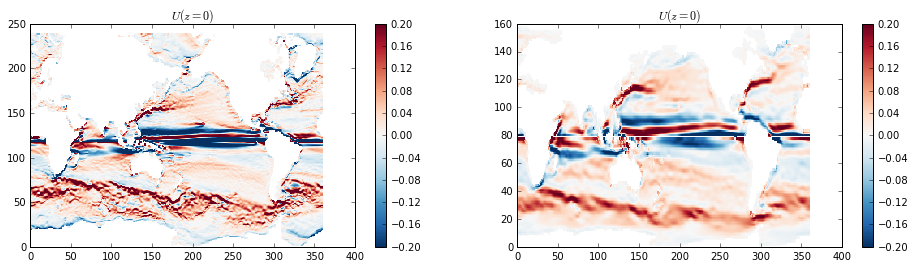

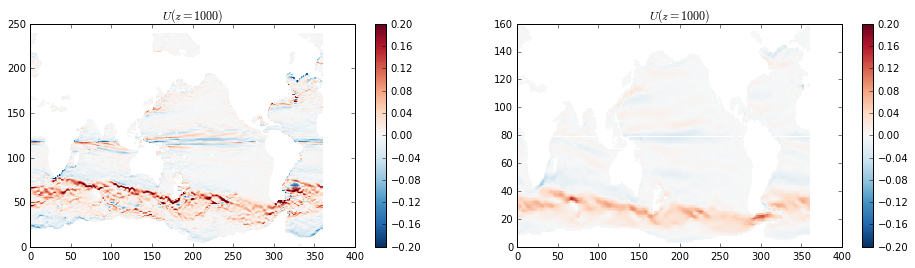

In [23]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(np.roll(Ug_sum_agg[0], -100, axis=1)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax1.set_title(r'$U (z=0)$')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(np.nanmean(Ug_ref[6:9, 0], axis=0)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax2.set_title(r'$U (z=0)$')
fig.colorbar(cax2)

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(np.roll(Ug_sum_agg[39], -100, axis=1)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax1.set_title(r'$U (z=1000)$')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(np.nanmean(Ug_ref[6:9, 29], axis=0)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax2.set_title(r'$U (z=1000)$')
fig.colorbar(cax2)

## $\boldsymbol{v}_g$

In [82]:
lonVg = .5 * (np.roll(lon, -1, axis=1) + lon)
rho_sumVg0 = .5 * (np.roll(rho_sum[0], -1, axis=1) + rho_sum[0])
rho_brack_sumVg = .5 * (np.roll(rho_brack_sum, -1, axis=2) + rho_brack_sum)
etaVg_sum = .5 * (np.roll(eta_sum, -1, axis=1) + eta_sum)

In [83]:
Vg_sum = 9.8 * (gsw.earth.f(lat)[np.newaxis] 
                               * rho_sumVg0[np.newaxis])**-1 * (rho_brack_sumVg * detadx_sum[np.newaxis] 
                               + (-etaVg_sum[np.newaxis] + zBot[:, np.newaxis, np.newaxis]) * drhodx_sum)

In [84]:
np.savez('POP_geostrophicVel_summer_nonagg',
        lonU=lon, latU=latUg, lonV=lonVg, latV=lat,
        Ug=Ug_sum, Vg=Vg_sum)

In [25]:
Nagg = 10

rho_brack_sumVg_agg = np.empty((rho_brack_sumVg.shape[0],
                  rho_brack_sumVg.shape[1]/Nagg, rho_brack_sumVg.shape[2]/Nagg))
rho_brack_sumVg_agg[:] = np.nan
rho_sumVg0_agg = np.empty((rho_sumVg0.shape[0]/Nagg, rho_sumVg0.shape[1]/Nagg))
rho_sumVg0_agg[:] = np.nan
drhodx_sum_agg = np.empty((drhodx_sum.shape[0],
                  drhodx_sum.shape[1]/Nagg, drhodx_sum.shape[2]/Nagg))
drhodx_sum_agg[:] = np.nan


for k in range(Nz-1):

    if k == 0:
        lonVg_agg = aggregate(lonVg, factor=Nagg)
        lat_agg = aggregate(lat, factor=Nagg)
        etaVg_sum_agg = aggregate(etaVg_sum, factor=Nagg)
        detadx_sum_agg = aggregate(detadx_sum, factor=Nagg)
        rho_sumVg0_agg = aggregate(rho_sumVg0, factor=Nagg)

    rho_brack_sumVg_agg[k] = aggregate(rho_brack_sumVg[k], factor=Nagg)
    drhodx_sum_agg[k] = aggregate(drhodx_sum[k], factor=Nagg)

In [26]:
Vg_sum_agg = 9.8 * (gsw.earth.f(lat_agg)[np.newaxis] 
                               * rho_sumVg0_agg[np.newaxis])**-1 * (rho_brack_sumVg_agg * detadx_sum_agg[np.newaxis] 
                               + (-etaVg_sum_agg[np.newaxis] + zBot[:, np.newaxis, np.newaxis]) * drhodx_sum_agg)

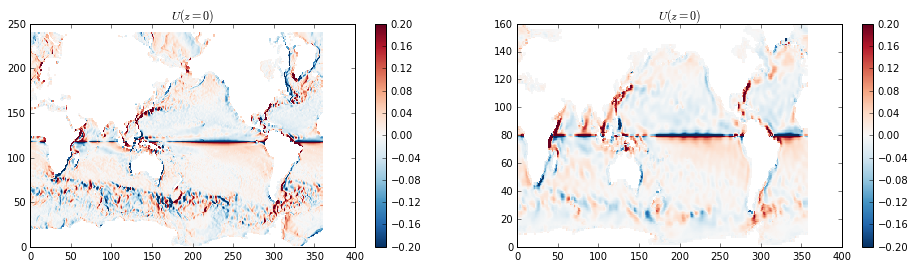

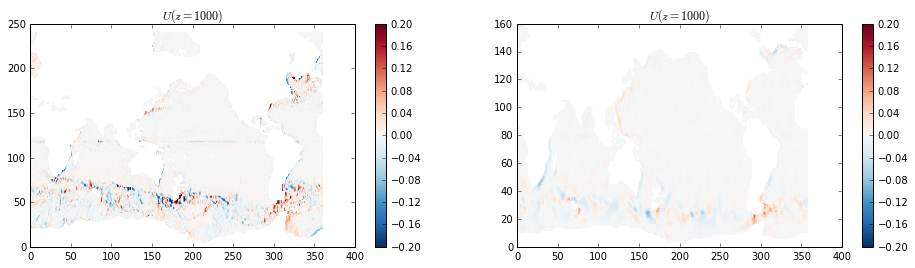

In [27]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(np.roll(Vg_sum_agg[0], -100, axis=1)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax1.set_title(r'$U (z=0)$')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(np.nanmean(Vg_ref[6:9, 0], axis=0)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax2.set_title(r'$U (z=0)$')
fig.colorbar(cax2)

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(np.roll(Vg_sum_agg[39], -100, axis=1)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax1.set_title(r'$U (z=1000)$')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(np.nanmean(Vg_ref[6:9, 29], axis=0)), 
                       cmap='RdBu_r', vmin=-2e-1, vmax=2e-1)
ax2.set_title(r'$U (z=1000)$')
fig.colorbar(cax2)

In [28]:
np.savez('POP_geostrophicVel_summer',
        Ug=Ug_sum_agg, Vg=Vg_sum_agg,
        latUg=latUg_agg, lon=lon_agg,
        lat=lat_agg, lonVg=lonVg_agg)

# $N^2$

In [39]:
seasons = np.array(['winter', 'summer'])

True
(61, 2400, 3600)


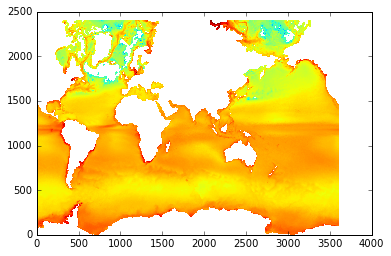

POP_Nsquared_winter
True
(61, 2400, 3600)


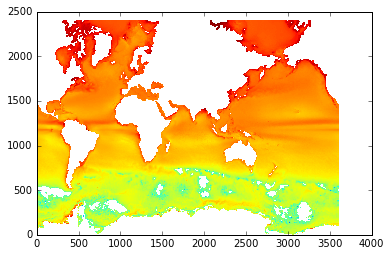

POP_Nsquared_summer


In [44]:
for season in seasons:
    
    fnamenpz = os.path.join(basedir, '../POP_ThermalVariables_%6s.npz' % season)
    consTabsS = np.load(fnamenpz)
    absS = consTabsS['absS']
    consT = consTabsS['consT']
    P = consTabsS['pressure']
    
    fname = os.path.join(basedir, 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-0081.%3s.timeavg.nc' % 'Jan')
    data = xray.open_dataset(fname, decode_times=False)
    print os.path.exists(fname)    
    maskT = data.KMT > 1
    latT = data.TLAT.where(maskT)
    
    N2, pN2 = gsw.Nsquared(absS, consT, P, latT)
    
    Nagg = 10
    Nz = N2.shape[0]
    N2_agg = np.empty((N2.shape[0],
                  N2.shape[1]/Nagg, N2.shape[2]/Nagg))
    pN2_agg = np.empty((pN2.shape[0],
                  pN2.shape[1]/Nagg, pN2.shape[2]/Nagg))
    
    for k in range(Nz):
        N2_agg[k] = aggregate(N2[k], factor=Nagg)
        pN2_agg[k] = aggregate(pN2[k], factor=Nagg)
    
    print N2.shape
    plt.pcolormesh(np.ma.masked_invalid(np.log10(N2[0])), 
                   cmap='jet')
    plt.show()
    
    save_name = os.path.join('POP_Nsquared_%6s' % season)
    print save_name
    np.savez(save_name,
            N2 = np.asarray(N2), p_N2 = np.asarray(pN2),
            N2_1deg=np.asarray(N2_agg), pN2_1deg=np.asarray(pN2_agg)
            )

In [5]:
npz = np.load('/data/scratch/takaya/POP_data/POP_Nsquared_Jan.npz')
N2_Jan = npz['N2']
pN2_Jan = npz['p_N2']

npz = np.load('/data/scratch/takaya/POP_data/POP_Nsquared_Feb.npz')
N2_Feb = npz['N2']
pN2_Feb = npz['p_N2']

npz = np.load('/data/scratch/takaya/POP_data/POP_Nsquared_Mar.npz')
N2_Mar = npz['N2']
pN2_Mar = npz['p_N2']

npz = np.load('/data/scratch/takaya/POP_data/POP_Nsquared_Jul.npz')
N2_Jul = npz['N2']
pN2_Jul = npz['p_N2']

npz = np.load('/data/scratch/takaya/POP_data/POP_Nsquared_Aug.npz')
N2_Aug = npz['N2']
pN2_Aug = npz['p_N2']

npz = np.load('/data/scratch/takaya/POP_data/POP_Nsquared_Sep.npz')
N2_Sep = npz['N2']
pN2_Sep = npz['p_N2']

In [6]:
N2_win = (31*N2_Jan + 28*N2_Feb + 31*N2_Mar) / (31 + 28 + 31)
N2_sum = (31*N2_Jul + 31*N2_Aug + 30*N2_Sep) / (31 + 31 + 30)
pN2_win = (31*pN2_Jan + 28*pN2_Feb + 31*pN2_Mar) / (31 + 28 + 31)
pN2_sum = (31*pN2_Jul + 31*pN2_Aug + 30*pN2_Sep) / (31 + 31 + 30)

In [7]:
save_name = os.path.join('POP_Nsquared_seasons')
np.savez(save_name,
        N2_win = N2_win, pN2_win = pN2_win,
        N2_sum = N2_sum, pN2_sum = pN2_sum,
        )